# Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import precision_score,accuracy_score, f1_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import mlflow
import mlflow.sklearn

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer,AutoFeatureExtractor, ViTForImageClassification, ViTFeatureExtractor
import torch
from torch.utils.data import  DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)
import datasets

import tensorflow as tf
from tensorflow.keras.utils import img_to_array

import fonctions_from_notebook_1

# Initialisation MLFlow

In [2]:
mlflow.set_tracking_uri("http://localhost:5000")  # Définir l'URI de suivi de MLflow (facultatif)
mlflow.set_experiment("OC - Projet 6 - Traitement image")

<Experiment: artifact_location='mlflow-artifacts:/457993710067892322', creation_time=1723019213507, experiment_id='457993710067892322', last_update_time=1723019213507, lifecycle_stage='active', name='OC - Projet 6 - Traitement image', tags={}>

# Préparation des datas pour l'entrainement

In [3]:
images_dir_OG= "./Datas/Images"
annotations_dir_OG= "./Datas/Annotation"
images_dir_S= "./Datas/Images_Small"
annotations_dir_S= "./Datas/Annotation_Small"
images_dir_M= "./Datas/Images_M"
annotations_dir_M= "./Datas/Annotation_M"
output_size=(224, 224)

# CODE

In [4]:
datas_raw = fonctions_from_notebook_1.get_dogs_picture_breed_raw(images_dir_M,annotations_dir_M,output_size)

Processing directories: 100%|██████████| 31/31 [00:27<00:00,  1.14it/s, current_directory=./Datas/Images_M\n02093428-American_Staffordshire_terrier]


In [5]:
datas_altered = fonctions_from_notebook_1.get_dogs_picture_breed(images_dir_M,annotations_dir_M,output_size)

Processing directories: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it, current_directory=./Datas/Images_M\n02093428-American_Staffordshire_terrier]


In [6]:
labels = datas_raw['breed'].unique()
label_to_index = {label: idx for idx, label in enumerate(labels)}
datas_raw['breed_idx'] = datas_raw['breed'].map(label_to_index)

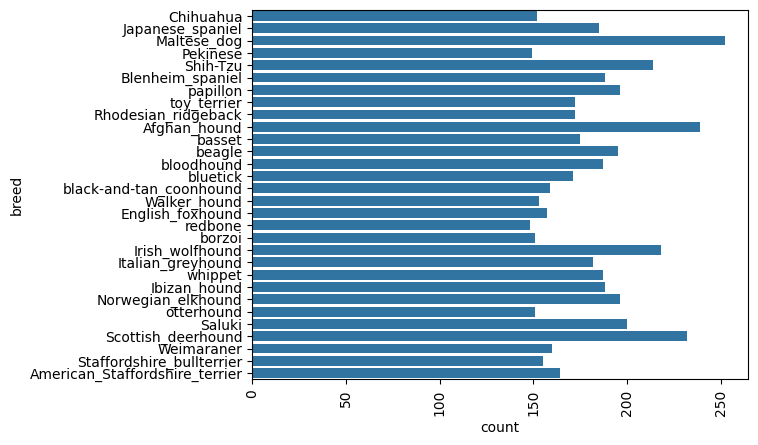

In [7]:
import seaborn as sns
sns.countplot(datas_raw['breed'])
plt.xticks(rotation=90)
plt.show()

In [8]:
def resize_images(image_list, target_size=(224, 224)):
    resized_images = []
    for image in image_list:
        if image.shape != target_size + (3,):
            print(image.shape)
            print("REZISE")
            image = tf.image.resize(image, target_size).numpy()
        resized_images.append(image)
    return np.array(resized_images)

# Appliquer la fonction de redimensionnement
X = resize_images(datas_raw['image'])
print(X.shape)  # Devrait maintenant être (20580, 224, 224, 3)

(5448, 224, 224, 3)


In [9]:
# Séparer les données en images et étiquettes
#X = np.array(datas['image'])
X = np.array([np.array(image) for image in datas_raw['image']])
print(X.shape)
y = to_categorical(datas_raw['breed_idx'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

(5448, 224, 224, 3)


In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


e:\Users\Beast-Of-War\miniconda3\envs\tf2_fresh\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
with mlflow.start_run(run_name=f"vgg16 - base"):
    mlflow.tensorflow.autolog()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=16,
        callbacks=[early_stopping]
    )

Epoch 1/10
273/273 [==============================] - 27s 64ms/step - loss: 14.4765 - accuracy: 0.0739 - val_loss: 8.9344 - val_accuracy: 0.1055
Epoch 2/10
273/273 [==============================] - 13s 49ms/step - loss: 5.5418 - accuracy: 0.2285 - val_loss: 6.9736 - val_accuracy: 0.1569
Epoch 3/10
273/273 [==============================] - 13s 48ms/step - loss: 2.8371 - accuracy: 0.4617 - val_loss: 6.4209 - val_accuracy: 0.1817
Epoch 4/10
273/273 [==============================] - 13s 48ms/step - loss: 1.4198 - accuracy: 0.6797 - val_loss: 6.1942 - val_accuracy: 0.1936
Epoch 5/10
273/273 [==============================] - 13s 47ms/step - loss: 0.6764 - accuracy: 0.8467 - val_loss: 6.0293 - val_accuracy: 0.2037
Epoch 6/10
273/273 [==============================] - 13s 48ms/step - loss: 0.3209 - accuracy: 0.9351 - val_loss: 5.9729 - val_accuracy: 0.2165
Epoch 7/10
273/273 [==============================] - 14s 50ms/step - loss: 0.1563 - accuracy: 0.9766 - val_loss: 5.9531 - val_accuracy

INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmpml1bmm0c\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmpml1bmm0c\model\data\model\assets
2024/08/09 01:58:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "e:\Users\Beast-Of-War\miniconda3\envs\tf2_fresh\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils."
2024/08/09 01:58:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run vgg16 - base at: http://localhost:5000/#/experiments/781273586351533022/runs/1ace3d3b97214ecab423d016c82fabf5.
2024/08/09 01:58:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/781273586351533022.


In [12]:
# Évaluation sur les données de validation
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy*100:.2f}%')

35/35 [==============================] - 79s 1s/step - loss: 5.9414 - accuracy: 0.2294
Validation accuracy: 22.94%


In [13]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir les probabilités en classes
y_true = np.argmax(y_val, axis=1)  # Convertir les étiquettes one-hot en classes

report = classification_report(y_true, y_pred_classes, target_names=labels)
print(report)

35/35 [==============================] - 14s 409ms/step
                                precision    recall  f1-score   support

                     Chihuahua       0.20      0.11      0.15        35
              Japanese_spaniel       0.25      0.34      0.29        41
                   Maltese_dog       0.43      0.53      0.47        55
                      Pekinese       0.07      0.10      0.09        30
                      Shih-Tzu       0.22      0.23      0.22        44
              Blenheim_spaniel       0.45      0.13      0.20        39
                      papillon       0.31      0.33      0.32        43
                   toy_terrier       0.06      0.06      0.06        32
           Rhodesian_ridgeback       0.21      0.17      0.19        40
                  Afghan_hound       0.39      0.44      0.41        41
                        basset       0.19      0.17      0.18        29
                        beagle       0.07      0.04      0.05        48
       

# using datagen

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Appliquer l'augmentation aux données d'entraînement uniquement
train_datagen = datagen.flow(X_train, y_train, batch_size=32)

In [15]:
with mlflow.start_run(run_name=f"vgg16 - datagen"):
    mlflow.tensorflow.autolog()
    history = model.fit(
    train_datagen,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
    )

2024/08/09 02:00:00 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/30
137/137 [==============================] - 65s 473ms/step - loss: 5.4420 - accuracy: 0.1494 - val_loss: 4.7264 - val_accuracy: 0.2440
Epoch 2/30
137/137 [==============================] - 34s 249ms/step - loss: 4.3672 - accuracy: 0.1597 - val_loss: 4.1769 - val_accuracy: 0.2661
Epoch 3/30
137/137 [==============================] - 34s 247ms/step - loss: 3.9960 - accuracy: 0.1804 - val_loss: 3.8424 - val_accuracy: 0.2835
Epoch 4/30
137/137 [==============================] - 33s 244ms/step - loss: 3.6910 - accuracy: 0.1905 - val_loss: 3.6069 - val_accuracy: 0.2881
Epoch 5/30
137/137 [==============================] - 34s 244ms/step - loss: 3.5518 - accuracy: 0.2109 - val_loss: 3.4279 - val_accuracy: 0.3018
Epoch 6/30
137/137 [==============================] - 34s 247ms/step - loss: 3.4233 - accuracy: 0.2141 - val_loss: 3.3160 - val_accuracy: 0.3138
Epoch 7/30
137/137 [==============================] - 33s 244ms/step - loss: 3.2549 - accuracy: 0.2269 - val_loss: 3.1287 - val_ac

2024/08/09 02:17:48 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/08/09 02:17:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp94hhflte\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmp94hhflte\model\data\model\assets
2024/08/09 02:18:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/09 02:18:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run vgg16 - datagen at: http://localhost:5000/#/experiments/781273586351533022/runs/f3592588265e4523bfdc3cc6ff79ca5c.
2024/08/09 02:18:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/781273586351533022.


In [16]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir les probabilités en classes
y_true = np.argmax(y_val, axis=1)  # Convertir les étiquettes one-hot en classes

report = classification_report(y_true, y_pred_classes, target_names=labels)
print(report)

35/35 [==============================] - 7s 180ms/step
                                precision    recall  f1-score   support

                     Chihuahua       0.38      0.31      0.34        35
              Japanese_spaniel       0.70      0.78      0.74        41
                   Maltese_dog       0.78      0.73      0.75        55
                      Pekinese       0.55      0.40      0.46        30
                      Shih-Tzu       0.51      0.61      0.56        44
              Blenheim_spaniel       0.77      0.62      0.69        39
                      papillon       0.63      0.77      0.69        43
                   toy_terrier       0.42      0.34      0.38        32
           Rhodesian_ridgeback       0.30      0.35      0.32        40
                  Afghan_hound       0.67      0.90      0.77        41
                        basset       0.30      0.28      0.29        29
                        beagle       0.33      0.23      0.27        48
        

# using my alterations

In [17]:
# toutesles images doivent etre altered pour l'entrainement

labels = datas_altered['breed'].unique()
label_to_index = {label: idx for idx, label in enumerate(labels)}
datas_altered['breed_idx'] = datas_altered['breed'].map(label_to_index)

# Appliquer la fonction de redimensionnement
X = resize_images(datas_altered['image'])
print(X.shape)  # Devrait maintenant être (20580, 224, 224, 3)

X = np.array([np.array(image) for image in datas_altered['image']])
print(X.shape)
y = to_categorical(datas_altered['breed_idx'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


(5448, 224, 224, 3)
(5448, 224, 224, 3)


In [18]:
# Entraîner le modèle# Entraînement du modèle
with mlflow.start_run(run_name=f"vgg16 - my alterations"):
    mlflow.tensorflow.autolog()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping]
    )

Epoch 1/30
137/137 [==============================] - 23s 163ms/step - loss: 3.6645 - accuracy: 0.1042 - val_loss: 3.6059 - val_accuracy: 0.0972
Epoch 2/30
137/137 [==============================] - 20s 148ms/step - loss: 3.0220 - accuracy: 0.1863 - val_loss: 3.6062 - val_accuracy: 0.1046
Epoch 3/30
137/137 [==============================] - 20s 145ms/step - loss: 2.5982 - accuracy: 0.2852 - val_loss: 3.6155 - val_accuracy: 0.1046
Epoch 4/30
137/137 [==============================] - 21s 151ms/step - loss: 2.2486 - accuracy: 0.3901 - val_loss: 3.6226 - val_accuracy: 0.1064
Epoch 5/30
137/137 [==============================] - 20s 146ms/step - loss: 1.9462 - accuracy: 0.4913 - val_loss: 3.6597 - val_accuracy: 0.1037
Epoch 6/30
1/1 [==============================] - 0s 35ms/step


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmpyg60a4rk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\BEAST-~1\AppData\Local\Temp\tmpyg60a4rk\model\data\model\assets
2024/08/09 02:21:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run vgg16 - my alterations at: http://localhost:5000/#/experiments/781273586351533022/runs/78c231c193d54504b65ee1eb3e121654.
2024/08/09 02:21:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/781273586351533022.


In [19]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir les probabilités en classes
y_true = np.argmax(y_val, axis=1)  # Convertir les étiquettes one-hot en classes

report = classification_report(y_true, y_pred_classes, target_names=labels)
print(report)

35/35 [==============================] - 4s 115ms/step
                                precision    recall  f1-score   support

                     Chihuahua       0.12      0.11      0.12        35
              Japanese_spaniel       0.26      0.15      0.19        41
                   Maltese_dog       0.25      0.24      0.24        55
                      Pekinese       0.06      0.03      0.04        30
                      Shih-Tzu       0.10      0.09      0.10        44
              Blenheim_spaniel       0.06      0.08      0.06        39
                      papillon       0.22      0.12      0.15        43
                   toy_terrier       0.05      0.06      0.06        32
           Rhodesian_ridgeback       0.09      0.07      0.08        40
                  Afghan_hound       0.10      0.15      0.12        41
                        basset       0.07      0.10      0.08        29
                        beagle       0.10      0.06      0.08        48
        

# RESNET

In [ ]:
output_size=(100, 100)

datas_raw =fonctions_from_notebook_1.get_dogs_picture_breed_raw(images_dir_M,annotations_dir_M,output_size)

In [ ]:
label_encoder = LabelEncoder()
datas_raw['labels'] = label_encoder.fit_transform(datas_raw['breed'])

label_to_id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id_to_label = {v: k for k, v in label_to_id.items()}

In [ ]:
train_img, val_img, train_labels, val_labels = train_test_split(datas_raw['image'], datas_raw['labels'], test_size=0.2, random_state=42)

In [ ]:
def transform(image,size=255.0):
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Convertir (H, W, C) en (C, H, W)
    return image / size

# Appliquer la transformation aux images
train_img_transformed = [transform(img) for img in train_img]
val_img_transformed = [transform(img) for img in val_img]

# Créer les datasets
train_dataset = Dataset.from_dict({"pixel_values": train_img_transformed, "labels": train_labels.tolist()})
val_dataset = Dataset.from_dict({"pixel_values": val_img_transformed, "labels": val_labels.tolist()})

In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
    }

In [ ]:
# Chargement d'un modèle pré-entraîné de type ResNet
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50", 
    num_labels=len(datas_raw['breed'].unique()),
    ignore_mismatched_sizes=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

In [ ]:
mlflow.set_experiment("ResNet Training with Transformers")

with mlflow.start_run():
    mlflow.log_param("learning_rate", training_args.learning_rate)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
    mlflow.log_param("num_train_epochs", training_args.num_train_epochs)
    mlflow.log_param("weight_decay", training_args.weight_decay)

    train_result = trainer.train()
    eval_result = trainer.evaluate()
    mlflow.log_metrics(eval_result)
    mlflow.pytorch.log_model(model, "model")
    print("Training completed and model logged with MLflow.")

In [ ]:
output_size=(100, 100)

datas_raw_OG =fonctions_from_notebook_1.get_dogs_picture_breed_raw(images_dir_OG,annotations_dir_OG,output_size)

label_encoder = LabelEncoder()
datas_raw_OG['labels'] = label_encoder.fit_transform(datas_raw_OG['breed'])

label_to_id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id_to_label = {v: k for k, v in label_to_id.items()}

train_img, val_img, train_labels, val_labels = train_test_split(datas_raw_OG['image'], datas_raw_OG['labels'], test_size=0.2, random_state=42)

# Chargement d'un modèle pré-entraîné de type ResNet
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model2 = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50", 
    num_labels=len(datas_raw_OG['breed'].unique()),
    ignore_mismatched_sizes=True)

trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
with mlflow.start_run(run_name=f"RESNET"):
    mlflow.log_param("learning_rate", training_args.learning_rate)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
    mlflow.log_param("num_train_epochs", training_args.num_train_epochs)
    mlflow.log_param("weight_decay", training_args.weight_decay)

    train_result = trainer.train()
    eval_result = trainer.evaluate()
    mlflow.log_metrics(eval_result)
    mlflow.pytorch.log_model(model, "model")

In [ ]:
#mlflow.set_experiment("ResNet Training with Transformers - all datas")

with mlflow.start_run(run_name=f"RESNET"):
    mlflow.log_param("learning_rate", training_args.learning_rate)
    mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
    mlflow.log_param("num_train_epochs", training_args.num_train_epochs)
    mlflow.log_param("weight_decay", training_args.weight_decay)

    train_result = trainer.train()
    eval_result = trainer.evaluate()
    mlflow.log_metrics(eval_result)
    mlflow.pytorch.log_model(model, "model")
    print("Training completed and model logged with MLflow.")

# Vision Transformer

In [4]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, load_metric

root_dir = './dataset-script-M'


Load the Dataset from local repo

In [5]:
ds = load_dataset("imagefolder", data_dir=root_dir)

Resolving data files:   0%|          | 0/4964 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1529 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1465 [00:00<?, ?it/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4964
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1529
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1465
    })
})

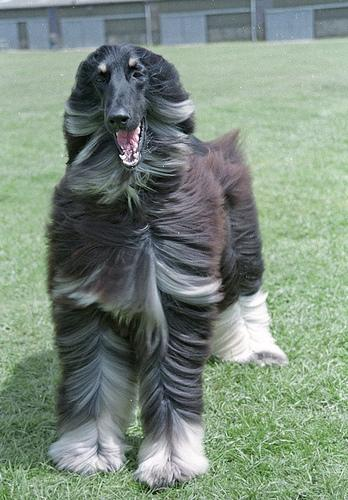

In [7]:
ds['train'][0]['image']

In [8]:
id_to_label = {id:label for id, label in enumerate(ds["train"].features['label'].names)}
label_to_id = {label:id for id,label in id_to_label.items()}
id_to_label

{0: 'Afghan_hound',
 1: 'American_Staffordshire_terrier',
 2: 'Blenheim_spaniel',
 3: 'Chihuahua',
 4: 'English_foxhound',
 5: 'Ibizan_hound',
 6: 'Irish_wolfhound',
 7: 'Italian_greyhound',
 8: 'Japanese_spaniel',
 9: 'Maltese_dog',
 10: 'Norwegian_elkhound',
 11: 'Pekinese',
 12: 'Rhodesian_ridgeback',
 13: 'Saluki',
 14: 'Scottish_deerhound',
 15: 'Staffordshire_bullterrier',
 16: 'Tzu',
 17: 'Walker_hound',
 18: 'Weimaraner',
 19: 'basset',
 20: 'beagle',
 21: 'bloodhound',
 22: 'bluetick',
 23: 'borzoi',
 24: 'otterhound',
 25: 'papillon',
 26: 'redbone',
 27: 'tan_coonhound',
 28: 'toy_terrier',
 29: 'whippet'}

Extracting Labels from Our Dataset

In [9]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['Afghan_hound', 'American_Staffordshire_terrier', 'Blenheim_spaniel', 'Chihuahua', 'English_foxhound', 'Ibizan_hound', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Maltese_dog', 'Norwegian_elkhound', 'Pekinese', 'Rhodesian_ridgeback', 'Saluki', 'Scottish_deerhound', 'Staffordshire_bullterrier', 'Tzu', 'Walker_hound', 'Weimaraner', 'basset', 'beagle', 'bloodhound', 'bluetick', 'borzoi', 'otterhound', 'papillon', 'redbone', 'tan_coonhound', 'toy_terrier', 'whippet'], id=None)

Defining the Transform Function

In [10]:
from PIL import Image
import torchvision.transforms as transforms

def transform(example_batch):
    # Define the desired image size
    desired_size = (224, 224)

    # Resize the images to the desired size
    resized_images = [transforms.Resize(desired_size)(x.convert("RGB")) for x in example_batch['image']]

    # Convert resized images to pixel values
    inputs = processor(resized_images, return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']

    return inputs

prepared_ds = ds.with_transform(transform)

In [11]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4964
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1529
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1465
    })
})

Defining the Collate Function and Metric Function

In [12]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy", trust_remote_code=True)

'''def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)'''

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

C:\Users\Beast-Of-War\AppData\Local\Temp\ipykernel_13848\3193473326.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


Loading the Pre-trained ViT Model

In [13]:
from transformers import AutoImageProcessor, ViTForImageClassification

model_name_or_path = 'google/vit-base-patch16-224-in21k'

processor = AutoImageProcessor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(ds["train"].features['label'].names),
    id2label=id_to_label,
    label2id=label_to_id,
    ignore_mismatched_sizes=True
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting Up Hyperparameters

In [14]:
root_dir = "./ViT_custom/"  # Path where all config files and checkpoints will be saved
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=5,
  #logging_steps=500,
  learning_rate=2e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

mlflow.set_experiment("vit - M")

'''with mlflow.start_run():
    train_results = trainer.train()
    # Sauvegarder le modèle
    save_dir = './ViT_custom/best_model/'
    trainer.save_model(save_dir)
    mlflow.log_metrics(train_results.metrics)
    mlflow.pytorch.log_model(trainer.model, "model")
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()'''

e:\Users\Beast-Of-War\miniconda3\envs\tf2_fresh\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


'with mlflow.start_run():\n    train_results = trainer.train()\n    # Sauvegarder le modèle\n    save_dir = \'./ViT_custom/best_model/\'\n    trainer.save_model(save_dir)\n    mlflow.log_metrics(train_results.metrics)\n    mlflow.pytorch.log_model(trainer.model, "model")\n    trainer.save_metrics("train", train_results.metrics)\n    trainer.save_state()'

In [15]:
mlflow.end_run()

In [18]:
mlflow.set_experiment("vit - M")

with mlflow.start_run():
    train_results = trainer.train()
    # Sauvegarder le modèle
    save_dir = './ViT_custom/best_model/'
    trainer.save_model(save_dir)
    mlflow.log_metrics(train_results.metrics)
    mlflow.pytorch.log_model(trainer.model, "model")
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()

  0%|          | 0/1555 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

mlflow.set_experiment("vit - S")

with mlflow.start_run():
    for epoch in range(int(training_args.num_train_epochs)):
        # Train for one epoch
        train_results = trainer.train(resume_from_checkpoint=None)
        
        # Calculate predictions on the training set
        predictions_output = trainer.predict(trainer.train_dataset)
        predictions = np.argmax(predictions_output.predictions, axis=-1)
        
        # Access the labels using the correct column name
        labels = trainer.train_dataset['label']
        
        # Calculate training metrics
        precision = precision_score(labels, predictions, average='weighted')
        recall = recall_score(labels, predictions, average='weighted')
        f1 = f1_score(labels, predictions, average='weighted')
        train_loss = predictions_output.metrics['test_loss']
        
        # Log training metrics with MLflow
        mlflow.log_metrics({
            'train_precision': precision,
            'train_recall': recall,
            'train_f1': f1,
            'train_loss': train_loss
        }, step=epoch)

        # Evaluate the model and log evaluation metrics
        eval_metrics = trainer.evaluate()
        mlflow.log_metrics(eval_metrics, step=epoch)

        # Save the best model
        trainer.save_model(f'./ViT_custom/best_model/epoch_{epoch + 1}')
        trainer.save_metrics("train", train_results.metrics)
        trainer.save_state()

    # Log the final model
    mlflow.pytorch.log_model(trainer.model, "model")

'''with mlflow.start_run():
    train2_results = trainer2.train()
    # Sauvegarder le modèle
    save_dir = './ViT_custom/best_model/'
    trainer2.save_model(save_dir)
    mlflow.log_metrics(train2_results.metrics)
    mlflow.pytorch.log_model(trainer2.model, "model")
    trainer2.save_metrics("train", train2_results.metrics)
    trainer2.save_state()'''

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.016619345173239708, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 19.793, 'eval_samples_per_second': 7.882, 'eval_steps_per_second': 1.01, 'epoch': 1.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.015136945061385632, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 19.7879, 'eval_samples_per_second': 7.884, 'eval_steps_per_second': 1.011, 'epoch': 2.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.014270064420998096, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 19.5814, 'eval_samples_per_second': 7.967, 'eval_steps_per_second': 1.021, 'epoch': 3.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.013785967603325844, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 19.1574, 'eval_samples_per_second': 8.143, 'eval_steps_per_second': 1.044, 'epoch': 4.0}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.013618530705571175, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 19.4332, 'eval_samples_per_second': 8.028, 'eval_steps_per_second': 1.029, 'epoch': 5.0}
{'train_runtime': 1148.6068, 'train_samples_per_second': 2.272, 'train_steps_per_second': 0.144, 'train_loss': 0.014896905783450964, 'epoch': 5.0}


  0%|          | 0/66 [00:00<?, ?it/s]

2024/08/12 21:44:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-duck-763 at: http://localhost:5000/#/experiments/835282927668866040/runs/d62414924c5640f99109da9a150c7f1f.
2024/08/12 21:44:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/835282927668866040.


KeyError: 'image'

In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

  0%|          | 0/184 [00:00<?, ?it/s]

***** test metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9447
  eval_loss               =     1.2155
  eval_runtime            = 0:03:25.87
  eval_samples_per_second =      7.116
  eval_steps_per_second   =      0.894


  0%|          | 0/184 [00:00<?, ?it/s]

Recall for Afghan_hound: 1.00
Recall for American_Staffordshire_terrier: 0.93
Recall for Blenheim_spaniel: 1.00
Recall for Chihuahua: 0.90
Recall for English_foxhound: 0.80
Recall for Ibizan_hound: 1.00
Recall for Irish_wolfhound: 0.89
Recall for Italian_greyhound: 0.94
Recall for Japanese_spaniel: 0.94
Recall for Maltese_dog: 1.00
Recall for Norwegian_elkhound: 1.00
Recall for Pekinese: 0.82
Recall for Rhodesian_ridgeback: 0.93
Recall for Saluki: 0.98
Recall for Scottish_deerhound: 0.97
Recall for Staffordshire_bullterrier: 0.69
Recall for Tzu: 0.97
Recall for Walker_hound: 0.88
Recall for Weimaraner: 1.00
Recall for basset: 0.96
Recall for beagle: 0.98
Recall for bloodhound: 0.96
Recall for bluetick: 1.00
Recall for borzoi: 0.97
Recall for otterhound: 1.00
Recall for papillon: 1.00
Recall for redbone: 0.89
Recall for tan_coonhound: 0.98
Recall for toy_terrier: 0.98
Recall for whippet: 0.84


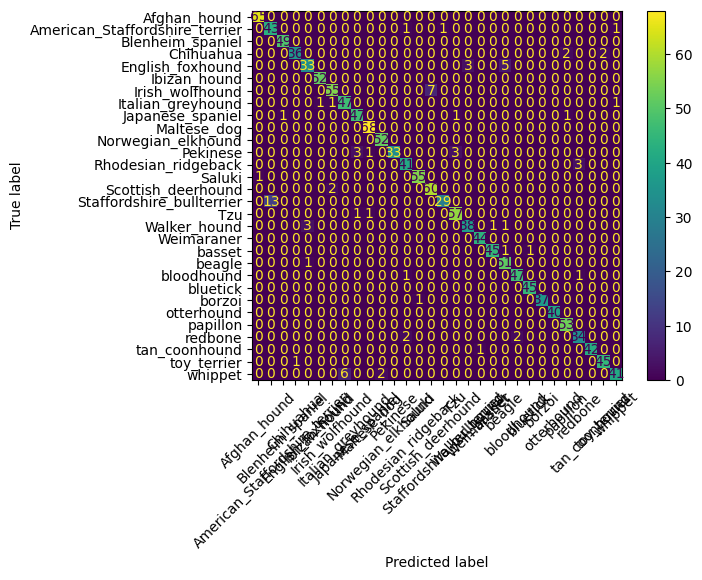

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

test_ds = ds['test'].with_transform(transform)
test_outputs = trainer.predict(test_ds)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

# YOLO v8

In [ ]:
root_dir = "./ViT_custom/"  # Path where all config files and checkpoints will be saved
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=5,
  #logging_steps=500,
  learning_rate=2e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

mlflow.set_experiment("vit - M")

'''with mlflow.start_run():
    train_results = trainer.train()
    # Sauvegarder le modèle
    save_dir = './ViT_custom/best_model/'
    trainer.save_model(save_dir)
    mlflow.log_metrics(train_results.metrics)
    mlflow.pytorch.log_model(trainer.model, "model")
    trainer.save_metrics("train", train_results.metrics)
    trainer.save_state()'''

e:\Users\Beast-Of-War\miniconda3\envs\tf2_fresh\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


'with mlflow.start_run():\n    train_results = trainer.train()\n    # Sauvegarder le modèle\n    save_dir = \'./ViT_custom/best_model/\'\n    trainer.save_model(save_dir)\n    mlflow.log_metrics(train_results.metrics)\n    mlflow.pytorch.log_model(trainer.model, "model")\n    trainer.save_metrics("train", train_results.metrics)\n    trainer.save_state()'

In [20]:
from ultralytics import YOLO

Pour pouvoir utiliser YOLOv8 dans la classification il a fallu mettre en place les data sous l'architecture  
  
---> Data  
 | ---> train  
 | | ---> "label 1"  
 | | | ---> dog.png  
 | | | ---> ...  
 | | ---> "label 2"  
 | | ---> ...  
 | ---> test  
 | | ---> "label 1"  
 | | ---> "label 2"  
 | | ---> ...  
 | ---> val  
 | | ---> "label 1"  
 | | ---> "label 2"  
 | | ---> ...  
  
  
Ce traitement a été effectué via l'exécution du fichier script.py


In [21]:
model = YOLO('yolov8n-cls.pt')

with mlflow.start_run(run_name=f"YOLO - full"):
    mlflow.tensorflow.autolog()
    model.train(data='./dataset-script-generated-FULL',epochs=30, imgsz=64)

New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.71  Python-3.10.14 torch-2.4.0 CPU (AMD Ryzen 5 5600X 6-Core Processor)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=./dataset-script-generated-FULL, epochs=30, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

e:\Users\Beast-Of-War\miniconda3\envs\tf2_fresh\lib\site-packages\ultralytics\engine\trainer.py:269: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning E:\Document\WorkSpace\Formation\Projet 6 - image\dataset-script-generated-FULL\train... 14458 images, 0 corrupt: 100%|██████████| 14458/14458 [00:00<?, ?it/s]

train: WARNING  E:\Document\WorkSpace\Formation\Projet 6 - image\dataset-script-generated-FULL\train\English_foxhound\n02089973_1763.jpg: corrupt JPEG restored and saved
train: WARNING  E:\Document\WorkSpace\Formation\Projet 6 - image\dataset-script-generated-FULL\train\English_foxhound\n02089973_2054.jpg: corrupt JPEG restored and saved



val: Scanning E:\Document\WorkSpace\Formation\Projet 6 - image\dataset-script-generated-FULL\val... 3141 images, 0 corrupt: 100%|██████████| 3141/3141 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)



2024/08/09 03:41:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2024/08/09 03:41:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/08/09 03:41:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


MLflow: logging run_id(c604cc81a2b14b9dbddd78c975369ea0) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING  Failed to initialize: Run 'c604cc81a2b14b9dbddd78c975369ea0' not found
MLflow: WARNING  Not tracking this run
TensorBoard: model graph visualization added 
Image sizes 64 train, 64 val
Using 0 dataloader workers
Logging results to runs\classify\train6
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30         0G      4.571         10         64: 100%|██████████| 904/904 [02:07<00:00,  7.08it/s]


MlflowException: Run 'c604cc81a2b14b9dbddd78c975369ea0' not found

In [ ]:
model_M = YOLO('yolov8n-cls.pt')

with mlflow.start_run(run_name=f"yolo - M"):
    mlflow.tensorflow.autolog()
    model_M.train(data='./dataset-script-M',epochs=30, imgsz=64)